# Tutorial on ensemble learning with scikit-learn

*Credits:* Based on [code written by A. Géron](https://github.com/ageron/handson-ml2) for his book ""Hands-on ML with scikit-learn, keras and tensorflow.", 2nd edition 2019, O'Reilly Media. Code realeased under [Apache-2.0 License](https://github.com/ageron/handson-ml2/blob/master/LICENSE).

In [6]:
import matplotlib.pyplot as plt
import sklearn
import numpy as np
import pandas as pd
import seaborn as sns
import scipy as sp
from scipy import stats


## Some useful plotting functions

In [7]:
from matplotlib.colors import ListedColormap

def plot_data(X, y, ax=None, axes=[-1.5, 2.45, -1, 1.5], alpha=0.5,y_pred=None):
    ax = ax or plt.gcf().gca()
    # plot data points
    ax.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    ax.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    if y_pred is not None:  # plot crosses over misclassified samples
        ax.plot(X[:, 0][y != y_pred], X[:, 1][y != y_pred], "kx", alpha=alpha,
                label='mistakes')
    ax.axis(axes)
    ax.set_xlabel(r"$x_1$", fontsize=18)
    ax.set_ylabel(r"$x_2$", fontsize=18, rotation=0)

def plot_decision_boundary(clf, X, y, ax=None, axes=[-1.5, 2.45, -1, 1.5], alpha=0.5, contour=True):
    if ax is None:
        ax = plt.gcf().gca()
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    ax.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        ax.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    # plot data points
    y_pred = clf.predict(X)
    plot_data(X, y, ax=ax, axes=axes, alpha=alpha, y_pred=y_pred)


# A few experiments with ensembles on toy data

Let's use the moons dataset:

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

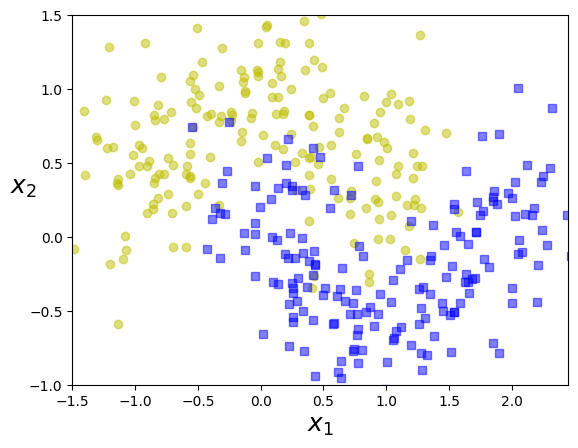

In [9]:
plot_data(X_train, y_train)

## Voting ensemble classifier

First we import and instantiate the induvisual classifiers constituting our ensemble:

In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression(solver="lbfgs", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma="scale", random_state=42)


Then, we can use [`VotingClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html#sklearn.ensemble.VotingClassifier) to combine the individual estimators:

In [11]:
from sklearn.ensemble import VotingClassifier
voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard')

Calling fit on the voting classifier will train the individual models:

In [12]:
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(random_state=42))])

We can access the individual estimators trained for the ensamble through the attribute `estimators_`:

In [13]:
voting_clf.estimators_

[LogisticRegression(random_state=42),
 RandomForestClassifier(random_state=42),
 SVC(random_state=42)]

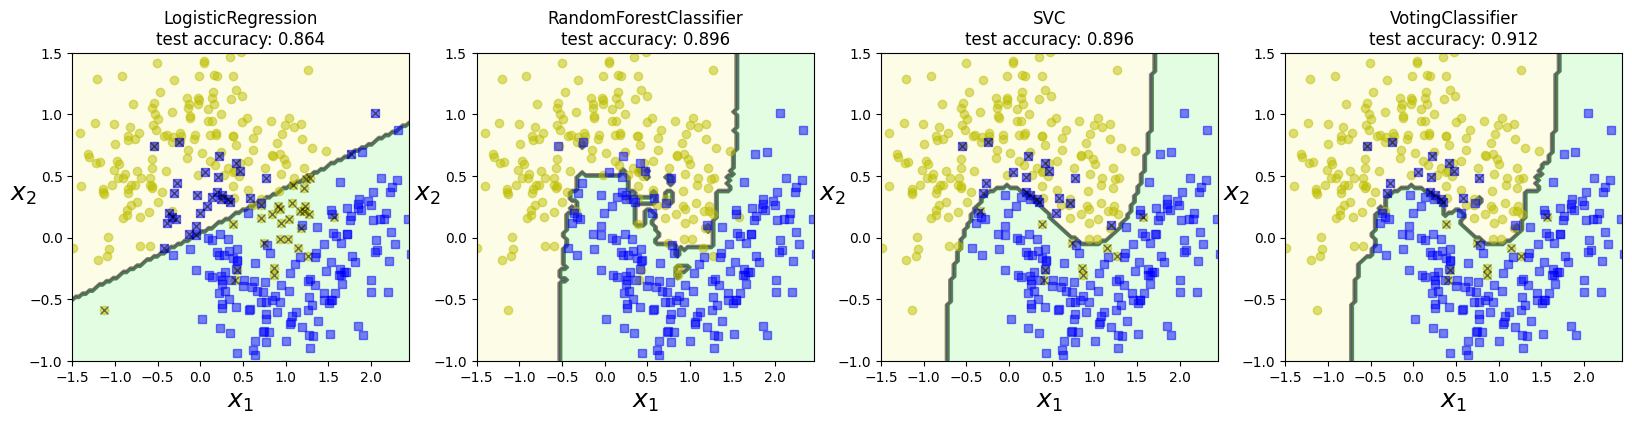

In [14]:
from sklearn.metrics import accuracy_score
fig, axs = plt.subplots(1, 4, figsize=(20,4))
for i, clf in enumerate((log_clf, rnd_clf, svm_clf, voting_clf)):
    # fit the model
    clf.fit(X_train, y_train)
    # compute predicitons on test set
    y_pred = clf.predict(X_test)
    # calculate accuracy on test set
    test_acc = accuracy_score(y_test, y_pred)
    # plot decision boundaries and accuracy score for each model
    ax = axs[i]
    plot_decision_boundary(clf, X_train, y_train, ax=ax)
    ax.set_title(clf.__class__.__name__ +
                 f"\ntest accuracy: {test_acc}")

### Diversity within the ensemble
The crosses at the previous plots mark misclassified samples. Notice how the models make different mistakes.

The code bellow shows the ids of the misclassified samples for each model:

In [15]:
individual_miss = set()
for model in voting_clf.estimators_:
    y_pred = model.predict(X_train)
    miss_ids = np.arange(X_train.shape[0])[y_pred != y_train]
    individual_miss = individual_miss.union(set(miss_ids))
    print(f"Mistakes on training set for model {model.__class__.__name__}: \nsamples {miss_ids}")

Mistakes on training set for model LogisticRegression: 
samples [  6   9  10  37  51  61  63  71  73  75  81  83  86  93  95  96  99 103
 106 107 110 113 118 127 142 146 155 161 164 180 185 195 197 205 209 213
 238 239 248 251 252 263 267 274 282 294 298 305 310 314 316 318 320 322
 325 355 358 361 363]
Mistakes on training set for model RandomForestClassifier: 
samples []
Mistakes on training set for model SVC: 
samples [ 18  37  51  53  63  83  96 106 107 127 155 194 195 197 209 213 226 251
 267 274 305 316 320 322 325 355 358 363]


The ensemble model allows to combine stengths and compensate weakeness of the composing models, finally making less mistakes

In [16]:
y_pred = voting_clf.predict(X_train)
miss_ids = np.arange(X_train.shape[0])[y_pred != y_train]
ensemble_miss = set(miss_ids)

print(f'union of individual mistakes: {len(individual_miss)} samples\n {sorted(individual_miss)}')
print(f'ensemble mistakes: {len(ensemble_miss)} samples\n {sorted(ensemble_miss)}' )

union of individual mistakes: 63 samples
 [6, 9, 10, 18, 37, 51, 53, 61, 63, 71, 73, 75, 81, 83, 86, 93, 95, 96, 99, 103, 106, 107, 110, 113, 118, 127, 142, 146, 155, 161, 164, 180, 185, 194, 195, 197, 205, 209, 213, 226, 238, 239, 248, 251, 252, 263, 267, 274, 282, 294, 298, 305, 310, 314, 316, 318, 320, 322, 325, 355, 358, 361, 363]
ensemble mistakes: 24 samples
 [37, 51, 63, 83, 96, 106, 107, 127, 155, 195, 197, 209, 213, 251, 267, 274, 305, 316, 320, 322, 325, 355, 358, 363]


Here you can see the predictions of each individual model for all the training samples over which one of them made mistakes

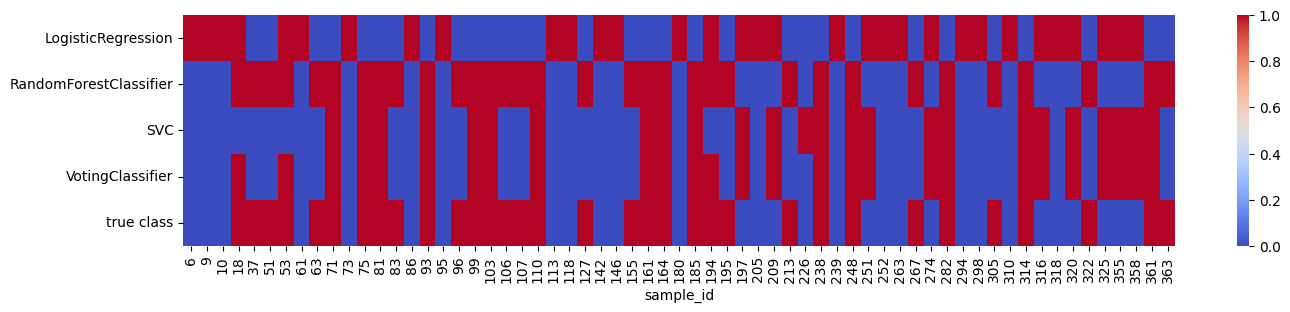

In [17]:
ids = np.array(sorted(individual_miss))
df = pd.DataFrame(index=ids)
df.rename_axis("sample_id", inplace=True)
for model in voting_clf.estimators_:
    y_pred = model.predict(X_train[ids])
    df[model.__class__.__name__] = y_pred
df[voting_clf.__class__.__name__] = voting_clf.predict(X_train[ids])
df["true class"] = y_train[ids]
fig, ax = plt.subplots(1,1, figsize=(16,3))
sns.heatmap(df.T, cmap='coolwarm', ax=ax);

The prediction output by the voting ensamble is computed by simple majority voting, as verified by the assert statement bellow:

In [18]:
df['Majority'] = df.aggregate(func=lambda x: stats.mode(x)[0][0], axis=1)
assert((df['VotingClassifier'] == df['Majority']).all())
df

/tmp/ipykernel_3706/1757920410.py:1: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  df['Majority'] = df.aggregate(func=lambda x: stats.mode(x)[0][0], axis=1)


,LogisticRegression,RandomForestClassifier,SVC,VotingClassifier,true class,Majority
sample_id,,,,,,
6,1,0,0,0,0,0
9,1,0,0,0,0,0
10,1,0,0,0,0,0
18,1,1,0,1,1,1
37,0,1,0,0,1,0
...,...,...,...,...,...,...
325,1,0,1,1,0,1
355,1,0,1,1,0,1
358,1,0,1,1,0,1


### Soft-Voting
The same class `VotingClassifier` can be used to combine estimators through a weighted voting method.
In this case, the voting is done by averaging the predicted class distributions of each individual classifier.

Do achieve it, just pass the argument `voting='soft'` to the constructor:



In [19]:
log_clf = LogisticRegression(solver="lbfgs", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma="scale", probability=True, random_state=42)

voting_clf_soft = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='soft')
voting_clf_soft.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(probability=True, random_state=42))],
                 voting='soft')

In [20]:
voting_clf_soft.score(X_test, y_test)

0.92

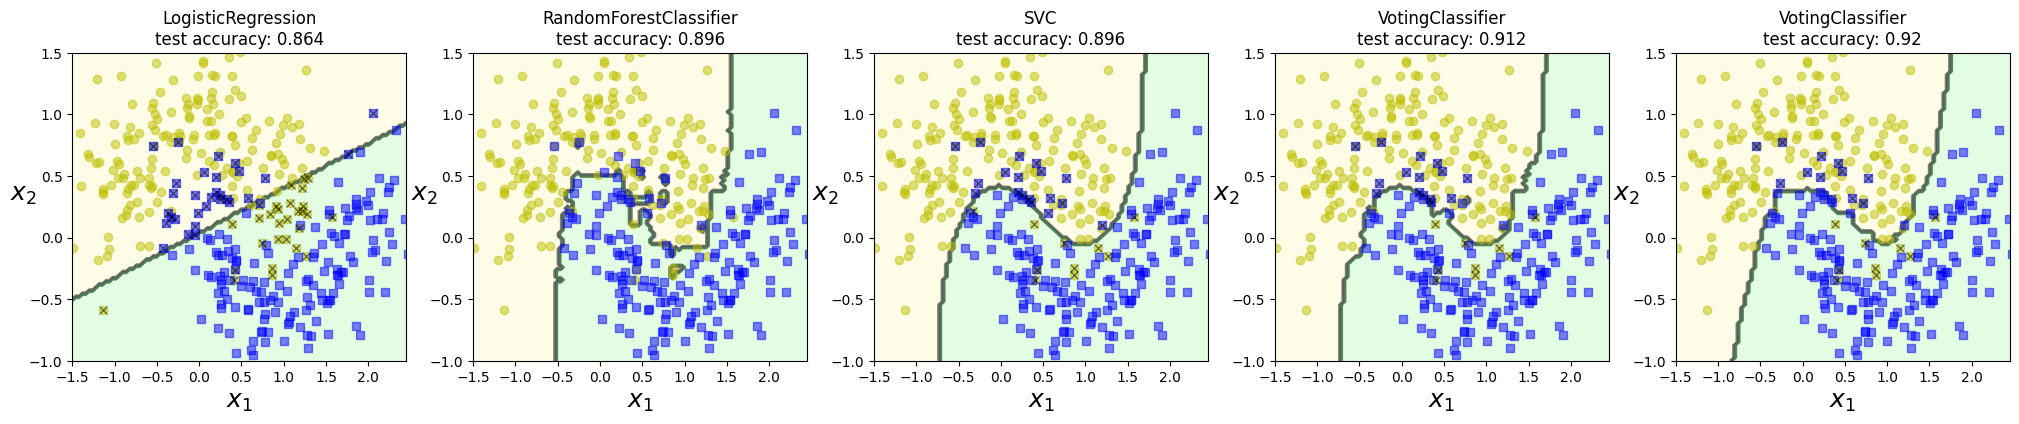

In [21]:
from sklearn.metrics import accuracy_score
fig, axs = plt.subplots(1, 5, figsize=(25,4))
for i, clf in enumerate((log_clf, rnd_clf, svm_clf, voting_clf, voting_clf_soft)):
    # fit the model
    clf.fit(X_train, y_train)
    # compute predicitons on test set
    y_pred = clf.predict(X_test)
    # calculate accuracy on test set
    test_acc = accuracy_score(y_test, y_pred)
    # plot decision boundaries and accuracy score for each model
    ax = axs[i]
    plot_decision_boundary(clf, X_train, y_train, ax=ax)
    ax.set_title(clf.__class__.__name__ +
                 f"\ntest accuracy: {test_acc}")

Here are some plots to visualize the predicted probabilities for each indivisual classifier. We plot the predicted probas of 20 samples misclassified by at least one of the models.

Note that if we average them manually, we obtain the same response as the `VotingClassifier` we just trained.

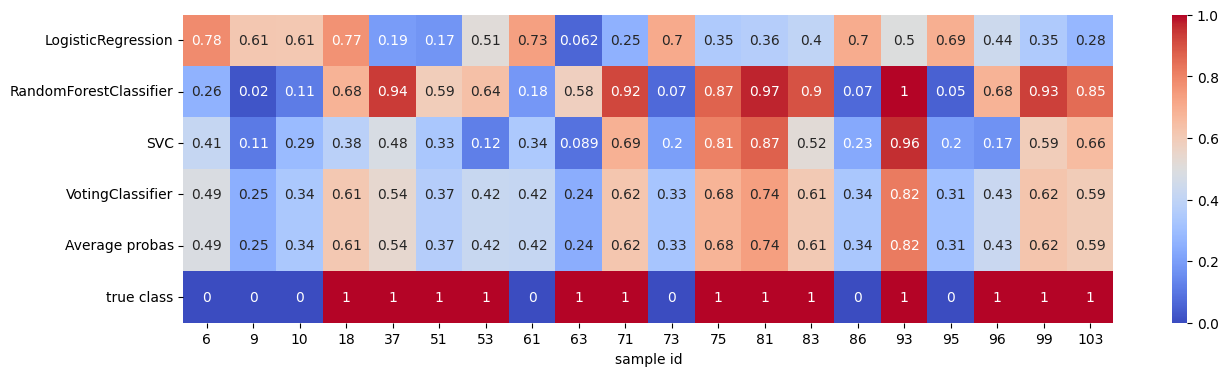

In [22]:
# Gathering samples misclassified by the base models
individual_miss = set()
for model in voting_clf_soft.estimators_:
    y_pred = model.predict(X_train)
    miss_ids = np.arange(X_train.shape[0])[y_pred != y_train]
    individual_miss = individual_miss.union(set(miss_ids))

# We'll focus on the first 20 samples for this visualization
ids = np.array(sorted(individual_miss))[:20]

# Here we collect all predicted probas for each model and the ensemble
pred_probas_df = pd.DataFrame(index=ids).rename_axis('sample id')
for i, model in enumerate(voting_clf_soft.estimators_+[voting_clf_soft]):
    # Here we'll manually compute the predicted probabilities
    # and save them to y_pred_agg
    y_pred_proba = model.predict_proba(X_train[ids])
    pred_probas_df[str(model.__class__.__name__)] = y_pred_proba[:,1]

# We inclde manually averaged probas into the dataframe
pred_probas_df["Average probas"] = pred_probas_df.iloc[:,0:3].mean(axis=1)
pred_probas_df["true class"] = y_train[ids]

# now we plot it all
fig, ax = plt.subplots(1,1, figsize=(15,4))
sns.heatmap(pred_probas_df.T, vmin=0, vmax=1, cmap='coolwarm',
            annot=True, ax=ax);

## Stacking ensemble
Stacking ensembles or model stacking is the practice of learning multiple estimators and combine them in a smarter way. Instead of simply doing voting or averaging the predictions, we train a model to combine this estimators on separate hold-out set. This model is sometimes called a *blender* model or a *meta-learner*.

Here is an example using a linear model as a blender. First we need to separate a hold-out split from our training data:

In [23]:
X_train_train, X_train_blend, y_train_train, y_train_blend  = train_test_split(X_train, y_train, test_size=0.3)

Now we train the estimators composing our ensemble on the training subset **without the held-out split**.

In [24]:
log_clf = LogisticRegression(solver="lbfgs", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma="scale", random_state=42)

for clf in (log_clf, rnd_clf, svm_clf):
    clf.fit(X_train_train, y_train_train)

Now we are going to use the hold-out split predictions of each individual estimator on the held-out set as training data for oure blending model.

First, let us gather this data by making predictions:

In [25]:
preds = {}
for clf in (log_clf, rnd_clf, svm_clf):
    preds[clf.__class__.__name__] = clf.predict(X_train_blend)
df = pd.DataFrame(preds)
df

,LogisticRegression,RandomForestClassifier,SVC
0,0,0,0
1,0,0,0
2,0,1,1
3,1,0,0
4,1,1,1
...,...,...,...
108,1,0,0
109,1,1,1
110,1,1,1
111,1,0,0


This data can now be used to train our linear blender (we will use a logistic regression since we are doing classification).

In [26]:
from sklearn.linear_model import LogisticRegression
blender = LogisticRegression(random_state=42)
blender.fit(df, y_train_blend)

LogisticRegression(random_state=42)

After fitting, the model has learned intercept and coeficients to combine the predictions of composing estimators:

In [27]:
blender.coef_, blender.intercept_

(array([[1.04408756, 1.50552669, 2.0949391 ]]), array([-2.1001713]))

Finally, we can combine models and blender to compute predictions and the accuracy score on the test set:

In [28]:
preds = {}
for clf in (log_clf, rnd_clf, svm_clf):
    preds[clf.__class__.__name__] = clf.predict(X_test)
df = pd.DataFrame(preds)
blender.score(df, y_test)

0.888

This performance is not realy better than that of the voting ensemble. There are some factors that could be at cause:
- stacking classifiers works better when combining the predictied probabilities instead of class labels.
- the size of the held-out dataset may not be big enough to generate sufficient samples for training the blender.
- the individual estimators were trained on a smaller training set.
- the linear model is not complex enough to learn a good blending function

We could train the estimators on the full training set, and do the hold-out split directly on the prediction data which is used to train the final model.
More over, we can use cross-validation to generate multiple hold-out splits and train the blender with better confidence.
We can also try to use a more complex model as a blender.

All of this can be achieved using the classes [`Stackingclassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingClassifier.html) or [`StackingRegressor`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingRegressor.html). They will train the estimators on the full training data and train the final blender using cross validation.

The default blender for classification is `LogisticRegression``. Notice how we get a similar score:

In [29]:
from sklearn.ensemble import StackingClassifier

stack = StackingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    cv=5)
stack.fit(X_train, y_train)
stack.score(X_test, y_test)

0.896

In [30]:
stack.final_estimator_.coef_, stack.final_estimator_.intercept_

(array([[-0.29315348,  0.80287311,  2.20560332]]), array([-0.0538289]))

Now let's  try again with a more complex blender model: `RandomForestClassifier`:

In [31]:
stack = StackingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    final_estimator=RandomForestClassifier(n_estimators=100, random_state=42), cv=5)
stack.fit(X_train, y_train)
stack.score(X_test, y_test)

0.912

## Bagging

Bagging classifiers can be created with `BaggingClassifier`. We need to pass another base estimator that will be fit by the constructor. Here is an example using decision trees:

In [32]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    max_samples=100, bootstrap=True, random_state=42)


When we call `fit` on the `BaggingClassifier` object, it will fit `n_estimator=500` trees on boostrapped subsets of the training data :

In [33]:
bag_clf.fit(X_train, y_train)

BaggingClassifier(estimator=DecisionTreeClassifier(), max_samples=100,
                  n_estimators=500, random_state=42)

Now we can use the bagging ensemble to make predictions on the test set

In [34]:
from sklearn.metrics import accuracy_score
y_pred = bag_clf.predict(X_test)
print("Test accuracy for the bagged ensemble of decision trees", accuracy_score(y_test, y_pred))

Test accuracy for the bagged ensemble of decision trees 0.904


We can access the individual estimators trained for the ensamble through the attribute `estimators_`. This box plot sumarizes the test performance of the 500 individual trees. As a reference, the green line marks the test performance of the bagged ensemble of these same trees.

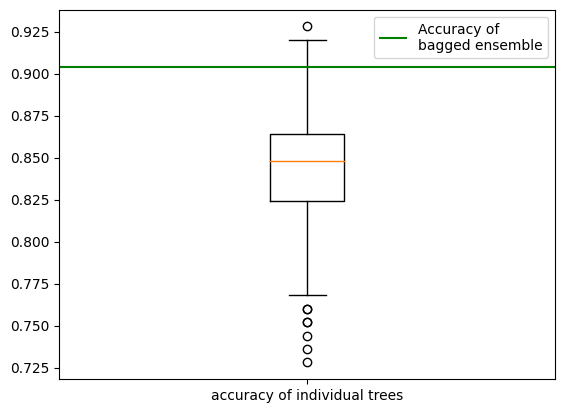

In [35]:
test_acc = []
for estim in bag_clf.estimators_:
    test_acc.append(estim.score(X_test, y_test))
plt.boxplot(test_acc);
plt.xticks([1],['accuracy of individual trees'])
plt.hlines(bag_clf.score(X_test, y_test), 0.5, 1.5, color='g', label='Accuracy of\nbagged ensemble')
plt.legend()

Here is an example comparison of a single decision tree against the bagged ensemble we just trained:

In [36]:
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
print("Test accuracy for a single decision tree", accuracy_score(y_test, y_pred_tree))

y_pred = bag_clf.predict(X_test)
print("Test accuracy for the bagged ensemble of decision trees", accuracy_score(y_test, y_pred))

Test accuracy for a single decision tree 0.856
Test accuracy for the bagged ensemble of decision trees 0.904


Text(0, 0.5, '')

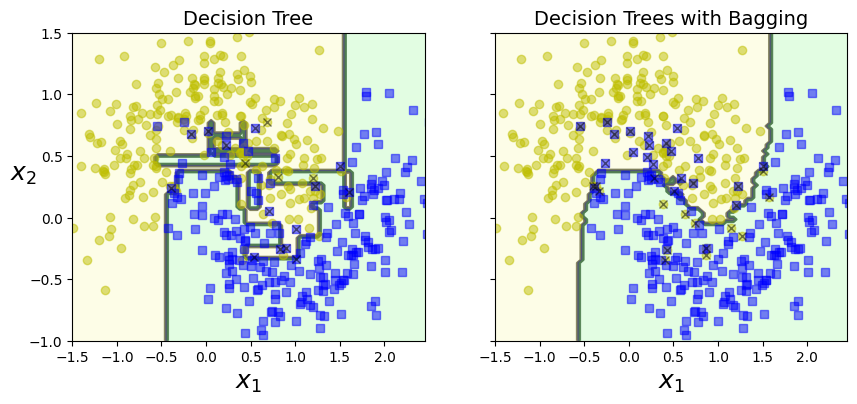

In [37]:
fix, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(tree_clf, X, y)
plt.title("Decision Tree", fontsize=14)
plt.sca(axes[1])
plot_decision_boundary(bag_clf, X, y)
plt.title("Decision Trees with Bagging", fontsize=14)
plt.ylabel("")

### Out-of-bag evaluation

Notice that in bagging, since each classifier is trained on a subsample fo the training set, there are always some unused training samples, that we call *out-of-bag*.
These samples can be used to evaluate the generalization of that individual classifier: this is called the *out-of-bag score* (or oob score) .

Averaging out-of-bag scores for all estimators can be a shortcut to estimating test performance without having to hold out and evaluate on separate validation set.

We can ask Scikit-learn to compute this average oob score as follows:


In [38]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    bootstrap=True, oob_score=True, random_state=40)
bag_clf.fit(X_train, y_train)
bag_clf.oob_score_.round(3)

0.899

Notice it is not too far from the test performance

In [39]:
bag_clf.score(X_test, y_test).round(3)

0.912